# Modeling Scale-Free Networks

Including a new model that generates graphs with small world properties and a lognormal degree distribution.

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import networkx as nx

from utils import decorate, savefig

In [2]:
np.random.seed(17)

## Introduction

Real social networks generally have the properties of small world graphs (high clustering and low path lengths) and the characteristics of scale free networks (a heavy-tailed degree distribution).

The Watts-Strogatz (WS) network model has small world characteristics, but the degree distribution is roughly normal, very different from observed distributions.

The Barabasi-Albert (BA) model has low path lengths and a heavy-tailed degree distribution, but

1. It has low clustering, and 
2. The degree distribution does not fit observed data well.

The Holmes-Kim (HK) model generates graphs with higher clustering, although still not as high as observed values.  And the degree distribution is heavy tailed, but it still doesn't fit observed distributions well.

I propose a new model that generates graphs with

1.  Low path lenths,
2.  Clustering coefficients similar to the HK model (but still lower than observed values), and
3.  A degree distribution that fits observed data well.

I test the models with a relatively small dataset from [SNAP](https://snap.stanford.edu/data/egonets-Facebook.html).

The proposed model is based on a "friend of a friend" growth mechanism that is a plausible description of the way social networks actually grow.  The implementation is simple, comparable to BA and HK in both lines of code and run time.

## Facebook data

The following function reads a file with one edge per line, specified by two integer node IDs.

In [3]:
def read_graph(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

We'll read the Facecook data downloaded from [SNAP](https://snap.stanford.edu/data/egonets-Facebook.html)

In [4]:
# https://snap.stanford.edu/data/facebook_combined.txt.gz

fb = read_graph('../data/facebook_combined.txt.gz')
n = len(fb)
m = len(fb.edges())
n, m

(4039, 88234)

The average clustering coefficient is about 0.6

In [5]:
from networkx.algorithms.approximation import average_clustering

In [6]:
C = average_clustering(fb)
C

0.621

The average path length is short.

In [7]:
def random_path_lengths(G, nodes=None, trials=1000):
    """Choose random pairs of nodes and compute the path length between them.

    G: Graph
    nodes: list of nodes to choose from
    trials: number of pairs to choose

    returns: list of path lengths
    """
    if nodes is None:
        nodes = G.nodes()
    else:
        nodes = list(nodes)
        
    pairs = np.random.choice(nodes, (trials, 2))
    lengths = [nx.shortest_path_length(G, *pair) 
               for pair in pairs]
    return lengths

def estimate_path_length(G, nodes=None, trials=1000):
    return np.mean(random_path_lengths(G, nodes, trials))

In [8]:
L = estimate_path_length(fb)
L

3.717

## WS model

Next I'll construct a WS graph with the same number of nodes and average degree as the Facebook network:

In [9]:
n = len(fb)
m = len(fb.edges())
k = int(round(2*m/n))
n, m, k

(4039, 88234, 44)

With `p=0.05`, we get clustering and path lengths similar to the Facebook data:

In [10]:
ws = nx.watts_strogatz_graph(n, k, p=0.05)
len(ws), len(ws.edges())

(4039, 88858)

The clustering coefficient in the model is a little higher than in the data.

In [11]:
C, average_clustering(ws)

(0.621, 0.649)

And the mean path length is a little smaller.

In [12]:
L, estimate_path_length(ws)

(3.717, 3.24)

So the WS model has the small world properties.  But the distribution of degrees is very different from the data.

This function extracts the list of degrees, one for each node.

In [13]:
def degrees(G):
    """List of degrees for nodes in `G`.
    
    G: Graph object
    
    returns: list of int
    """
    return [G.degree(u) for u in G]

The mean degree is about right:

In [14]:
np.mean(degrees(fb)), np.mean(degrees(ws))

(43.69101262688784, 44.0)

But the standard deviation isn't even close.

In [15]:
np.std(degrees(fb)), np.std(degrees(ws))

(52.41411556737521, 1.436275340309608)

We can see what's going on by plotting the distributions:

In [16]:
from empiricaldist import Pmf

pmf_fb = Pmf.from_seq(degrees(fb))
pmf_ws = Pmf.from_seq(degrees(ws))

The degree distribution in the WS graph is roughly Gaussian.  The degree distribution in social networks is emphatically not Gaussian.

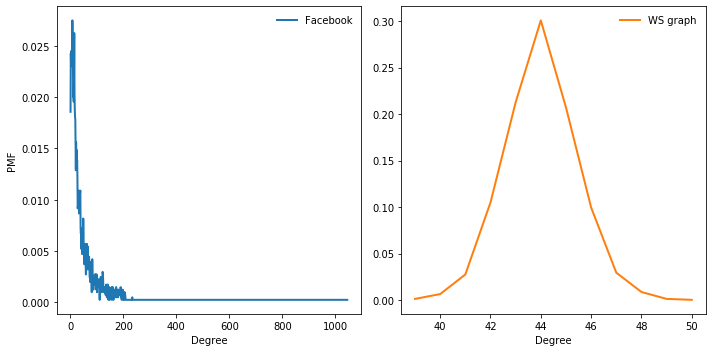

In [17]:
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
pmf_fb.plot(label='Facebook', color='C0')
decorate(xlabel='Degree', ylabel='PMF')

plt.subplot(1,2,2)
pmf_ws.plot(label='WS graph', color='C1')
decorate(xlabel='Degree')

And that discrepancy is at least part of the motivation for the BA model.

## BA model

Here's a simplified version of the NetworkX function that generates BA graphs.

In [18]:
import random

# modified version of the NetworkX implementation from
# https://github.com/networkx/networkx/blob/master/networkx/generators/random_graphs.py

def barabasi_albert_graph(n, m, seed=None):
    """Returns a random graph according to the Barabási–Albert preferential
    attachment model.
    A graph of `n` nodes is grown by attaching new nodes each with `m`
    edges that are preferentially attached to existing nodes with high degree.
    Parameters
    ----------
    n : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes
    seed : int, optional
        Seed for random number generator (default=None).
    Returns
    -------
    G : Graph
    Raises
    ------
    NetworkXError
        If `m` does not satisfy ``1 <= m < n``.
    References
    ----------
    .. [1] A. L. Barabási and R. Albert "Emergence of scaling in
       random networks", Science 286, pp 509-512, 1999.
    """

    if m < 1 or  m >=n:
        raise nx.NetworkXError("Barabási–Albert network must have m >= 1"
                               " and m < n, m = %d, n = %d" % (m, n))
        
    if seed is not None:
        random.seed(seed)
    
    G = nx.empty_graph(m)
    targets = list(range(m))
    repeated_nodes = []

    for source in range(m, n):

        G.add_edges_from(zip([source]*m, targets))

        repeated_nodes.extend(targets)
        repeated_nodes.extend([source] * m)

        targets = _random_subset(repeated_nodes, m)

    return G

def _random_subset(repeated_nodes, m):
    """Generates a random subset without repetition.
    
    repeated_nodes: sequence of nodes
    m: number of nodes to sample
    
    returns: set of nodes
    """
    targets = set()
    while len(targets) < m:
        x = random.choice(repeated_nodes)
        targets.add(x)
    return targets

I'll generate a BA graph with the same number of nodes and edges as the Facebook data:

In [19]:
n = len(fb)
m = len(fb.edges())
k = int(round(m/n))
n, m, k

(4039, 88234, 22)

Providing a random seed means we'll get the same graph every time.

In [20]:
ba = barabasi_albert_graph(n, k, seed=15)

The number of edges is pretty close to what we asked for.

In [21]:
len(ba), len(ba.edges()), len(ba.edges())/len(ba)

(4039, 88374, 21.88016835850458)

So the mean degree is about right.

In [22]:
np.mean(degrees(fb)), np.mean(degrees(ba))

(43.69101262688784, 43.76033671700916)

The standard deviation of degree is a bit lower than it should be (but much better than the WS model).

In [23]:
np.std(degrees(fb)), np.std(degrees(ba))

(52.41411556737521, 41.03760075705614)

Let's take a look at the degree distributions.

In [24]:
pmf_fb = Pmf.from_seq(degrees(fb))
pmf_ba = Pmf.from_seq(degrees(ba))

Looking at the PMFs on a linear scale, we see one difference, which is that the BA model has no nodes with degree less than `k`, which is 22.

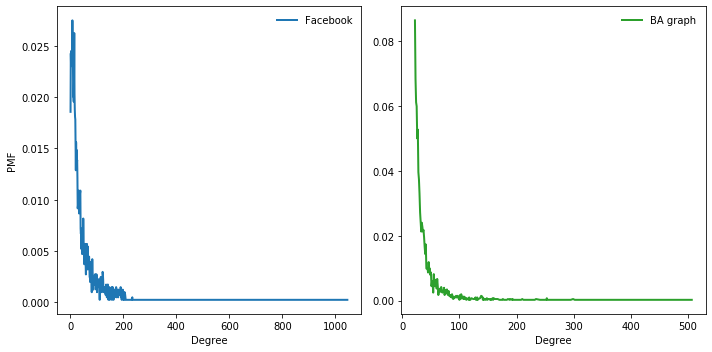

In [25]:
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
pmf_fb.plot(label='Facebook', color='C0')
decorate(xlabel='Degree', ylabel='PMF')

plt.subplot(1,2,2)
pmf_ba.plot(label='BA graph', color='C2')
decorate(xlabel='Degree')

If we look at the PMF on a log-log scale, the BA model looks pretty good for values bigger than about 20.  And it seems to follow a power law.

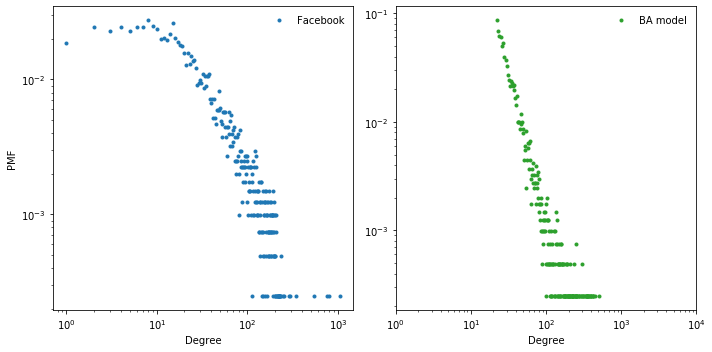

In [26]:
plt.figure(figsize=(10, 5))
options = dict(ls='', marker='.')

plt.subplot(1,2,1)

pmf_fb.plot(label='Facebook', color='C0', **options)
decorate(xlabel='Degree', ylabel='PMF',
         xscale='log', yscale='log')

plt.subplot(1,2,2)

pmf_ba.plot(label='BA model', color='C2', **options)
decorate(xlabel='Degree',
         xlim=[1, 1e4],
         xscale='log', yscale='log')

The characteristic path length is even smaller in the model than in the data.

In [27]:
L, estimate_path_length(ba)

(3.717, 2.513)

But the clustering coefficient isn't even close.

In [28]:
C, average_clustering(ba)

(0.621, 0.048)

In the BA model, the degree distribution is better than in the WS model, but the clustering coefficient is too low.

## Cumulative distributions

We can get a better picture of these distributions, and the differences between the model and the data, by plotting CDFs instead of PMFs.

In [29]:
from empiricaldist import Cdf

cdf_fb = Cdf.from_seq(degrees(fb), name='Facebook')
cdf_ws = Cdf.from_seq(degrees(ws), name='WS model')
cdf_ba = Cdf.from_seq(degrees(ba), name='BA model')

If we plot them on a log-x scale, we get a sense of how well the models fit the central part of the distribution.

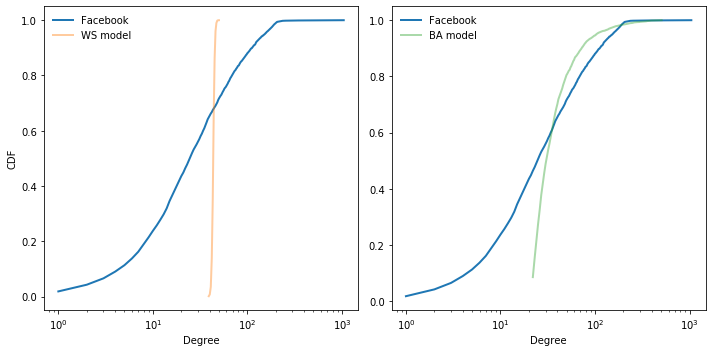

In [30]:
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
cdf_fb.plot(color='C0')
cdf_ws.plot(color='C1', alpha=0.4)
decorate(xlabel='Degree', xscale='log',
                 ylabel='CDF')

plt.subplot(1,2,2)
cdf_fb.plot(color='C0', label='Facebook')
cdf_ba.plot(color='C2', alpha=0.4)
decorate(xlabel='Degree', xscale='log')

The WS model is hopeless.  The BA model is ok for values above the median, but not very good for smaller values.

On a log-log scale, we see that the BA model fits the tail of the distribution reasonably well.

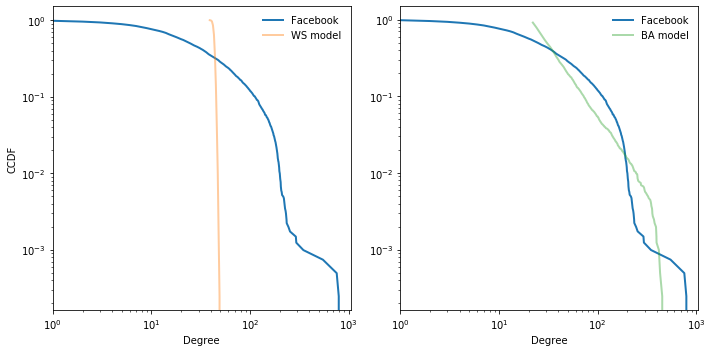

In [31]:
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
(1 - cdf_fb).plot(color='C0')
(1 - cdf_ws).plot(color='C1', alpha=0.4)
decorate(xlabel='Degree', xscale='log',
                 ylabel='CCDF', yscale='log')

plt.subplot(1,2,2)

(1 - cdf_fb).plot(color='C0', label='Facebook')
(1 - cdf_ba).plot(color='C2', alpha=0.4)
decorate(xlabel='Degree', xscale='log',
                 yscale='log')

## HK model

The Holme-Kim (HK) model is similar to the BA model, but it generates additional triangles in order to increase the clustering coefficient.

Here's a slightly simplified version of the NetworkX function that generates BA graphs:

In [32]:
# modified version of the NetworkX implementation from
# https://github.com/networkx/networkx/blob/master/networkx/generators/random_graphs.py

def powerlaw_cluster_graph(n, m, p, seed=None):
    """Holme and Kim algorithm for growing graphs with powerlaw
    degree distribution and approximate average clustering.
    Parameters
    ----------
    n : int
        the number of nodes
    m : int
        the number of random edges to add for each new node
    p : float,
        Probability of adding a triangle after adding a random edge
    seed : int, optional
        Seed for random number generator (default=None).
    Notes
    -----
    The average clustering has a hard time getting above a certain
    cutoff that depends on `m`.  This cutoff is often quite low.  The
    transitivity (fraction of triangles to possible triangles) seems to
    decrease with network size.
    It is essentially the Barabási–Albert (BA) growth model with an
    extra step that each random edge is followed by a chance of
    making an edge to one of its neighbors too (and thus a triangle).
    This algorithm improves on BA in the sense that it enables a
    higher average clustering to be attained if desired.
    It seems possible to have a disconnected graph with this algorithm
    since the initial `m` nodes may not be all linked to a new node
    on the first iteration like the BA model.
    Raises
    ------
    NetworkXError
        If `m` does not satisfy ``1 <= m <= n`` or `p` does not
        satisfy ``0 <= p <= 1``.
    References
    ----------
    .. [1] P. Holme and B. J. Kim,
       "Growing scale-free networks with tunable clustering",
       Phys. Rev. E, 65, 026107, 2002.
    """

    if m < 1 or n < m:
        raise nx.NetworkXError(\
              "NetworkXError must have m>1 and m<n, m=%d,n=%d"%(m,n))

    if p > 1 or p < 0:
        raise nx.NetworkXError(\
              "NetworkXError p must be in [0,1], p=%f"%(p))
    if seed is not None:
        random.seed(seed)

    G = nx.empty_graph(m) # add m initial nodes (m0 in barabasi-speak)
    G.name="Powerlaw-Cluster Graph"
    repeated_nodes = list(G.nodes()) # list of existing nodes to sample from
                           # with nodes repeated once for each adjacent edge
        
    for source in range(m, n):
        possible_targets = _random_subset(repeated_nodes,m)
        # do one preferential attachment for new node
        target=possible_targets.pop()
        G.add_edge(source,target)
        repeated_nodes.append(target) # add one node to list for each new link
        count=1
        while count<m:  # add m-1 more new links
            if random.random()<p: # clustering step: add triangle
                neighborhood=[nbr for nbr in G.neighbors(target) \
                               if not G.has_edge(source,nbr) \
                               and not nbr==source]
                if neighborhood: # if there is a neighbor without a link
                    nbr=random.choice(neighborhood)
                    G.add_edge(source,nbr) # add triangle
                    repeated_nodes.append(nbr)
                    count=count+1
                    continue # go to top of while loop
            # else do preferential attachment step if above fails
            target=possible_targets.pop()
            G.add_edge(source,target)
            repeated_nodes.append(target)
            count=count+1

        repeated_nodes.extend([source]*m)  # add source node to list m times
    return G

In [33]:
n = len(fb)
m = len(fb.edges())
k = int(round(m / n))
n, m, k

(4039, 88234, 22)

In [34]:
hk = powerlaw_cluster_graph(n, k, 1.0, seed=15)
len(hk), len(hk.edges())

(4039, 88363)

The clustering coefficient is better than in the BA model, but still subtantially lower than in the dataset.

In [35]:
C, average_clustering(hk)

(0.621, 0.277)

The path lengths are very short.

In [36]:
L, estimate_path_length(hk)

(3.717, 2.762)

The mean degree is about right, but the standard deviation is a little low.

In [37]:
np.mean(degrees(fb)), np.mean(degrees(hk))

(43.69101262688784, 43.75488982421391)

In [38]:
np.std(degrees(fb)), np.std(degrees(hk))

(52.41411556737521, 43.106377456263075)

The distribution of degrees is pretty much the same as from the BA model.  It doesn't fit the lower and central parts of the distribution well.

In [39]:
cdf_hk = Cdf.from_seq(degrees(hk), name='HK model')

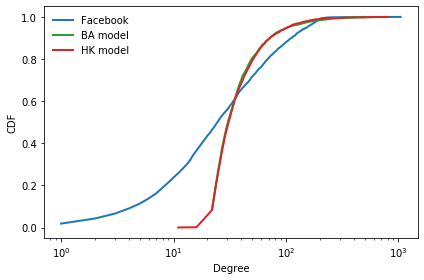

In [40]:
cdf_fb.plot(color='C0')
cdf_ba.plot(color='C2')
cdf_hk.plot(color='C3')
decorate(xlabel='Degree',
         ylabel='CDF',
         xscale='log')

But it fits the tail of the distribution reasonably well.

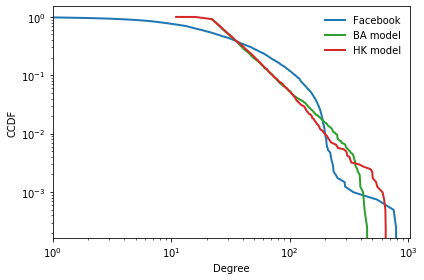

In [41]:
(1 - cdf_fb).plot(color='C0')
(1 - cdf_ba).plot(color='C2')
(1 - cdf_hk).plot(color='C3')
decorate(xlabel='Degree',
         ylabel='CCDF',
         xscale='log', yscale='log', loc='upper right')

## FOF model

The generative model I propose is called FOF for "friends of friends".  It is similar to both BA and HK, but it yields a degree distribution that matches observed data better.

It starts with a complete graph with `m` nodes, so initially all nodes have degree `m`.  Each time we generate a node we:

1.  Select a random target uniformly from existing nodes.
2.  Iterate through the friends of the target.  For each one, with probability `p`, we form a triangle that includes the source, friend, and a random friend of friend.
3.  Finally, we connect the source and target.

Because we choose friends of the target, this process has preferential attachment, but it does not yield a power law tail.  Rather, the degree distribution is approximately lognormal with median degree `m`.

Because this process forms triangles, it tends to yield a moderately high clustering coefficient.

Here's what my implementation looks like:

In [42]:
def fof_graph(n, m, p=0.25, seed=None):
    """Makes a small world graph with a lognormal degree distribution."""
    if m < 1 or  m+1 >= n:
        raise nx.NetworkXError(\
              "FOF network must have m>=1 and m+1<n, m=%d,n=%d"%(m,n))
    if seed is not None:
        random.seed(seed)

    # start with a completely connected core
    G = nx.complete_graph(m+1)
    G.name="fof_graph(%s,%s)"%(n,m)

    for source in range(len(G), n):
        # choose a random node
        target = random.choice(list(G.nodes))
        
        # enumerate neighbors of target and add triangles
        friends = list(G.neighbors(target))
        for friend in friends:
            if flip(p):
                triangle(G, source, friend)

        # connect source and target
        G.add_edge(source, target)
            
    return G

def flip(p):
    return random.random() < p

def triangle(G, source, friend):
    """Chooses a random neighbor of `friend` and makes a triangle.
    
    Triangle connects `source`, `friend`, and a random neighbor of `friend`.
    """
    fof = set(G[friend])
    if source in G:
        fof -= set(G[source])
    if fof:
        w = random.choice(list(fof))
        G.add_edge(source, w)
    G.add_edge(source, friend)

The parameter `m` is the average degree.

In [43]:
n = len(fb)
m = int(round(np.mean(degrees(fb))))
n, m

(4039, 44)

The parameter `p` is the probability of adding a triangle.  Since each triangle increases the total degree by 4, keeping `p` near `1/4` tends to keep `m` constant.

In [44]:
fof = fof_graph(n, m, p=0.24, seed=21)
len(fof), len(fof.edges())

(4039, 83137)

The clustering coefficient is similar to what we get from the HK model.

In [45]:
C, average_clustering(fof)

(0.621, 0.257)

The average path length is low.

In [46]:
L, estimate_path_length(fof)

(3.717, 3.215)

The degree distribution fits the observed data well

In [47]:
cdf_fof = Cdf.from_seq(degrees(fof), name='FOF')

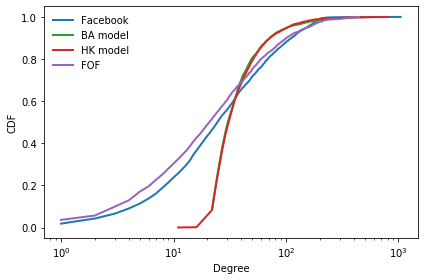

In [48]:
cdf_fb.plot(color='C0')
cdf_ba.plot(color='C2')
cdf_hk.plot(color='C3')
cdf_fof.plot(color='C4')

decorate(xlabel='Degree',
         ylabel='CDF',
         xscale='log')

On a log-log scale, the model fits the data well except in the extreme tail.

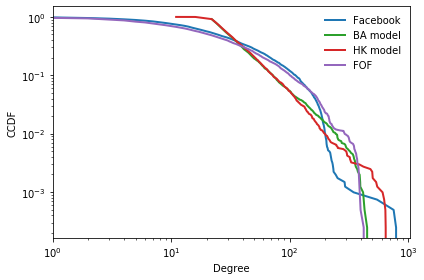

In [49]:
(1 - cdf_fb).plot(color='C0')
(1 - cdf_ba).plot(color='C2')
(1 - cdf_hk).plot(color='C3')
(1 - cdf_fof).plot(color='C4')

decorate(xlabel='Degree',
         ylabel='CCDF',
         xscale='log', yscale='log')

In summary, the FOF model has 

* Short path lengths, like WS, BA, and HK.
* Moderate clustering, similar to HK, less than WS, and higher than BA.
* Good fit to the tail of the degree distribution, like BA and HK.
* Good fit to the rest of the degree distribution, unlike WS, BA, and HK.

Also, the mechanism of growth is plausible: when a person joins the network, they connect to a randomly-chosen friend and then a random subset of "friends of friends".  This process has preferential attachment because friends of friends are more likely to have high degree (see [The Inspection Paradox is Everywhere](http://allendowney.blogspot.com/2015/08/the-inspection-paradox-is-everywhere.html)).  But the resulting distribution is approximately lognormal, which is heavy tailed, but does not have a power law tail.